In [161]:
import sys
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import os
import itertools
import socket
from datetime import datetime
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt


import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored
from IPython.display import display
from IPython.display import clear_output

In [162]:
print(os.getcwd())

C:\Users\zchodan\OneDrive - Franklin Templeton\Documents\Python\Kaggle\Playground Series\s4e12 - Insurance Premiums


In [163]:
# Declare important variables
train_path = 'train.csv'
solve_path = 'test.csv'
target_variable = 'Premium Amount'
SEED = 69

In [164]:
def load_dataframes(path1: str, path2: str, format1: str = "csv", format2: str = "csv") -> tuple:

    if socket.gethostname() == 'zchodani-p-l01':
        file_directory = r"C:\Users\zchodaniecky\OneDrive - Franklin Templeton\Documents\Python\Kaggle\Playground Series\s4e12 - Insurance Premiums"
    elif socket.gethostname() == 'FTILC3VBil7BwCe':
        file_directory = r"C:\Users\zchodan\OneDrive - Franklin Templeton\Documents\Python\Kaggle\Playground Series\s4e12 - Insurance Premiums"
    else:
        file_directory = r"C:\Users\zanec\OneDrive\Documents\Python\Kaggle\Playground Series\s4e12 - Insurance Premiums"
         
    os.chdir(file_directory)

    loaders = {
        "csv": pd.read_csv,
        "excel": pd.read_excel,
        "json": pd.read_json,
    }

    if format1 not in loaders or format2 not in loaders:
        raise ValueError("Unsupported format. Supported formats: 'csv', 'excel', 'json'.")

    # Load the dataframes using appropriate loaders
    df1 = loaders[format1](path1)
    df2 = loaders[format2](path2)

    return df1, df2

In [165]:
df_train, df_solve = load_dataframes(train_path,solve_path)

In [166]:
df_train_id = df_train['id']
df_train = df_train.drop('id',axis=1)

df_solve_id = df_solve['id']
df_solve = df_solve.drop('id',axis=1)

In [167]:
from typing import Tuple

def plot_kde_grid(df: pd.DataFrame, n_cols: int = 4, figsize: Tuple[int, int] = (12,8)) -> None:
    """
    Plots KDE for all numeric columns in the dataframe in a grid layout.
    
    Parameters:
        df (pd.DataFrame): DataFrame with numeric columns to plot.
        n_cols (int): Number of columns in the grid (default is 3).
        figsize (tuple): Size of the entire figure (default is (12, 8)).
    
    Returns:
        None
    """
    # Get numeric columns
    numeric_cols = df.select_dtypes(include='number').columns
    
    # Set up grid size
    n_rows = int(np.ceil(len(numeric_cols) / n_cols))  # Number of rows based on the number of features
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize))  # Adjust figure size
    axes = axes.flatten()  # Flatten to easily iterate
    
    # Plot each numeric column
    for i, col in enumerate(numeric_cols):
        sns.kdeplot(data=df, x=col, fill=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Density')
    
    # Hide any unused subplots
    for i in range(len(numeric_cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

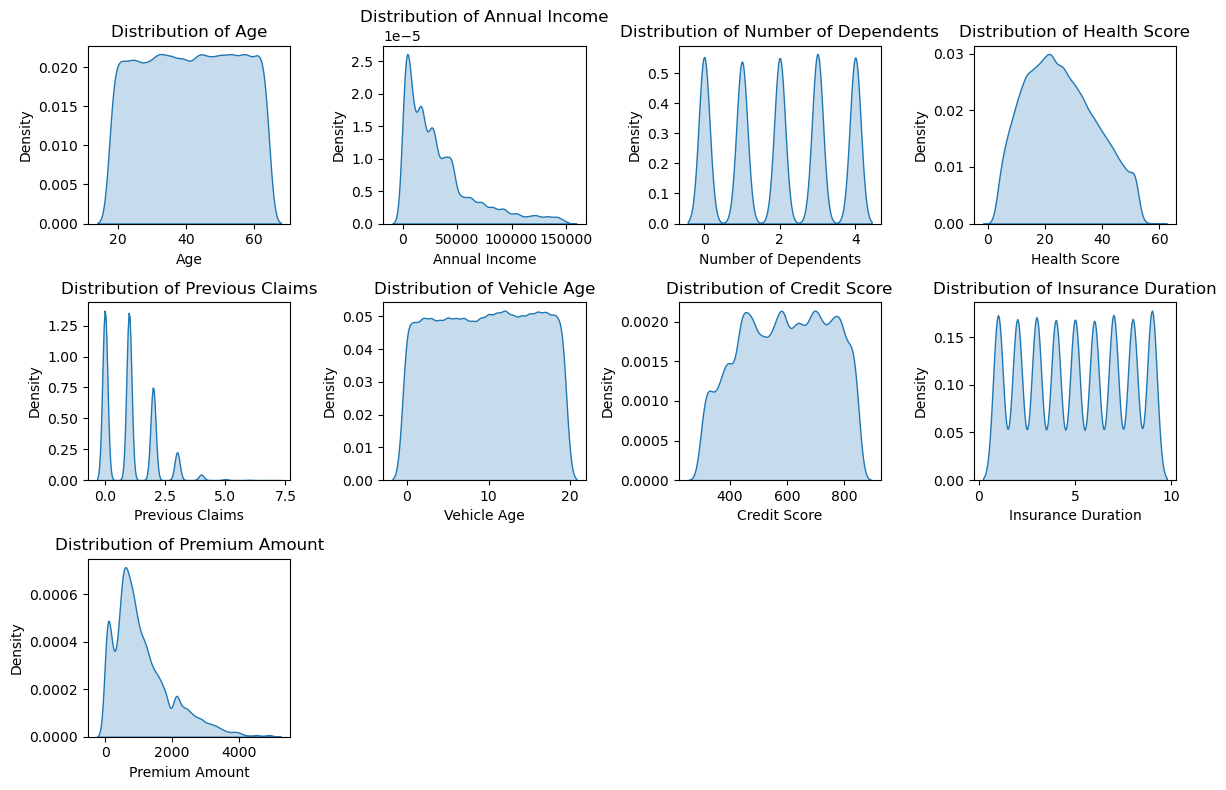

In [168]:
plot_kde_grid(df_train,n_cols=4,figsize=(12,8))

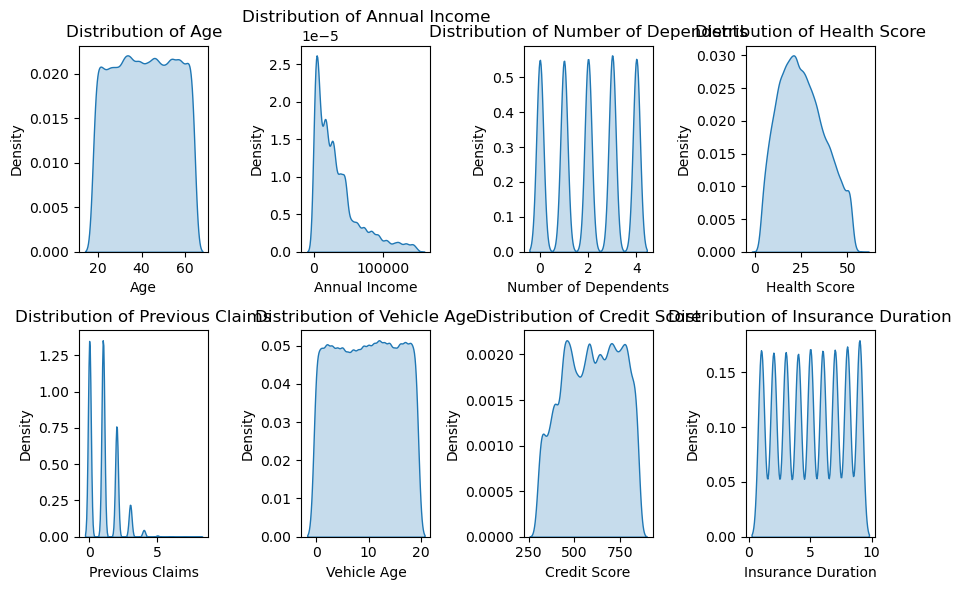

In [169]:
plot_kde_grid(df_solve,n_cols=4,figsize=(9,6))

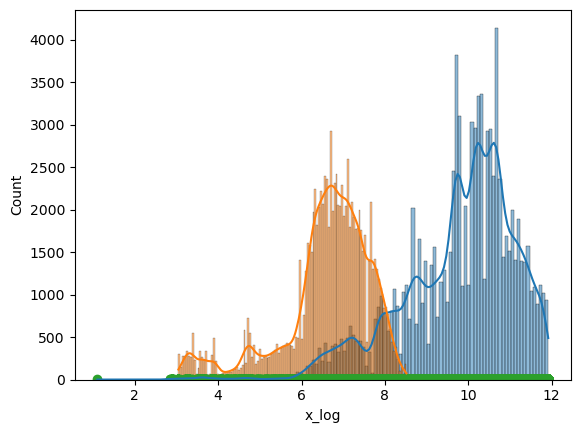

In [170]:
""" Annual Income and Premium Amount look to have some sort of correlation
    and both are right skew, lets look close
"""
df_hist = pd.DataFrame()
df_hist['x_log'] = np.log(df_train['Annual Income'] + 1)   # Add 1 to avoid log(0)
df_hist['y_log'] = np.log(df_train['Premium Amount'] + 1)  # Add 1 to avoid log(0)

# Plot histograms to check for skewness
sns.histplot(df_hist['x_log'], kde=True)
sns.histplot(df_hist['y_log'], kde=True)

# Scatter plot to check correlation between x and y
plt.scatter(df_hist['x_log'], df_hist['y_log'])
plt.show()

In [171]:
def describe_dataframe(df_to_use: pd.DataFrame, name: str = 'DataFrame', nrows: int = 3, plots: bool = False, info: bool = True) -> None:
    '''
    Function to describe the DataFrame with summary statistics, missing value count,
    unique value count, and duplicate count. It also displays plots for missing and unique values.
    
    Parameters:
    - df: The DataFrame to describe.
    - name: The name to display in the summary (default is 'DataFrame').
    - nrows: The number of rows to display from the top and bottom (default is 3).
    - plots: Whether to display bar plots for missing and unique values (default is False).
    - info: Whether to display the styled DataFrame (default is True).
    '''

    df = df_to_use.copy()
    
    # Create summary DataFrame
    inf = pd.DataFrame(df.dtypes).reset_index().rename(columns={'index':'column', 0:'type'})
    
    # Missing values
    df_missing = pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={'index':'column', 0:'missing'})
    df_missing['pct_missing'] = (df_missing['missing'] / df.shape[0]) * 100
    
    # Unique values
    df_unique = pd.DataFrame(df.nunique()).reset_index().rename(columns={'index':'column', 0:'unique'})
    
    # Combine summary information
    inf['missing'] = df_missing['missing']
    inf['pct_missing'] = df_missing['pct_missing']
    inf['unique'] = df_unique['unique']
    inf['duplicate'] = df.duplicated().sum()

    # Descriptive statistics
    desc = pd.DataFrame(df.describe(include='all').transpose())
    if 'min' in desc.columns.tolist():
        inf['min'] = desc['min'].values
        inf['max'] = desc['max'].values
        inf['avg'] = desc['mean'].values
        inf['std dev'] = desc['std'].values
    if 'top' in desc.columns.tolist():
        inf['top value'] = desc['top'].values
        inf['Freq'] = desc['freq'].values 
    
    # Display styled DataFrame
    if info:
        display(inf.style.background_gradient(subset=['missing','pct_missing'], cmap='Reds').background_gradient(subset='unique', cmap='Greens'))

    if nrows != 0 :
        # Display top and bottom nrows of the DataFrame
        print(f"\n---------- {name} Overview ----------:")
        print(f"{name} has {df.shape[0]} rows and {df.shape[1]} columns\n")
        display(df.head(nrows))
        display(df.tail(nrows))
    
    # Plot missing values if any
    if plots and df_missing['missing'].sum() > 0:
        fig, ax = plt.subplots(1, 1, figsize=(24, 5))
        sns.barplot(df_missing[df_missing['missing'] > 0], x='column', y='missing', ax=ax)
        ax.set_title(f'{name} missing Values') 
        ax.bar_label(ax.containers[0])
        plt.tight_layout()
        plt.show()
    
    # Plot unique values
    fig, ax = plt.subplots(1, 1, figsize=(24, 5))
    sns.barplot(df_unique[df_unique['unique'] > 0], x='column', y='unique', ax=ax)
    ax.set_title(f'{name} Unique Values')
    ax.bar_label(ax.containers[0])
    plt.tight_layout()
    plt.show()

In [172]:
def get_num_cols(df: pd.DataFrame) -> None:
    num_cols = df.select_dtypes(include=[np.float64, np.int64, np.int32]).columns.to_list()
    
    return num_cols

In [173]:
def get_cat_cols(df: pd.DataFrame) -> None:
    cat_cols = df.select_dtypes(include=['object', 'string']).columns.tolist()  

    return cat_cols

In [174]:
def clean_dataframe(df_to_use: pd.DataFrame, impute_num_cols: bool = True, fill_cat_cols: bool = True) -> None:
    df = df_to_use.copy()
    
    # inf = pd.DataFrame(df.dtypes).reset_index().rename(columns={'index':'column', 0:'type'})
    # df_missing = pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={'index':'column', 0:'missing'})  
    # # Merge the two DataFrames on 'column'
    # inf['missing'] = df_missing['missing'] 
    # Filter columns where the type is either 'float' or 'int' and there are missing values
    numeric_cols = df.select_dtypes(include=[np.float64, np.int64, np.int32]).columns
    missing_numeric_columns = [
        col for col in numeric_cols if df[col].isnull().sum() > 0
    ]

    # Fill nulls in numeric columns with the median
    if impute_num_cols:       
        for column in missing_numeric_columns:
            mdn = df[column].median()
            df[column] = df[column].fillna(mdn)

    
    # Get category columns
    if fill_cat_cols:
        cat_cols = df.select_dtypes(include=['object', 'string']).columns.tolist()  
        # Fill missing values in object columns
        for column in cat_cols:
            df[column] = df[column].fillna('Unknown')
    
    return df

In [175]:
def transform_dataframe(df_to_use: pd.DataFrame) -> None:
    
    df = df_to_use.copy()
    
    # Transform Date Fields
    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])
    df['Year'] = df['Policy Start Date'].dt.year
    df['Day'] = df['Policy Start Date'].dt.day
    df['Month'] = df['Policy Start Date'].dt.month
    df['Month Name'] = df['Policy Start Date'].dt.month_name()
    df['Day of Week'] = df['Policy Start Date'].dt.day_name()
    df['Year Sin'] = np.sin(2 * np.pi * df['Year'])
    df['Month Sin'] = np.sin(2 * np.pi * df['Month'] / 12) 
    df['Month Cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Day Sin'] = np.sin(2 * np.pi * df['Day'] / 31)  
    df['Day Cos'] = np.cos(2 * np.pi * df['Day'] / 31)
    
    df = df.drop('Policy Start Date', axis=1)
    
    
       # Creating Ratio variables, as well as categorizing continuous ones
    df['Claims v Duration'] = df['Previous Claims'] / df['Insurance Duration']
    
    return df

In [176]:
# Clean and Transform Data

In [177]:
df_train_cleaned = clean_dataframe(df_train)
df_solve_cleaned = clean_dataframe(df_solve)

In [178]:
df_train_prepared = transform_dataframe(df_train_cleaned)
df_solve_prepared = transform_dataframe(df_solve_cleaned)

In [179]:
# Inspect Data through phases of clean and transform

,column,type,missing,pct_missing,unique,duplicate,min,max,avg,std dev,top value,Freq
0,Age,float64,1540,1.540000,47,0,18.000000,64.000000,41.176000,13.549630,nan,nan
1,Gender,object,0,0.000000,2,0,nan,nan,nan,nan,Male,50407
2,Annual Income,float64,3792,3.792000,33760,0,2.000000,149996.000000,32761.461750,32179.156965,nan,nan
3,Marital Status,object,1553,1.553000,3,0,nan,nan,nan,nan,Single,33251
4,Number of Dependents,float64,9105,9.105000,5,0,0.000000,4.000000,2.007976,1.415089,nan,nan
5,Education Level,object,0,0.000000,4,0,nan,nan,nan,nan,Bachelor's,25374
6,Occupation,object,29818,29.818000,3,0,nan,nan,nan,nan,Employed,23568
7,Health Score,float64,5968,5.968000,76632,0,2.053458,58.886035,25.609103,12.195576,nan,nan
8,Location,object,0,0.000000,3,0,nan,nan,nan,nan,Suburban,33628
9,Policy Type,object,0,0.000000,3,0,nan,nan,nan,nan,Premium,33844


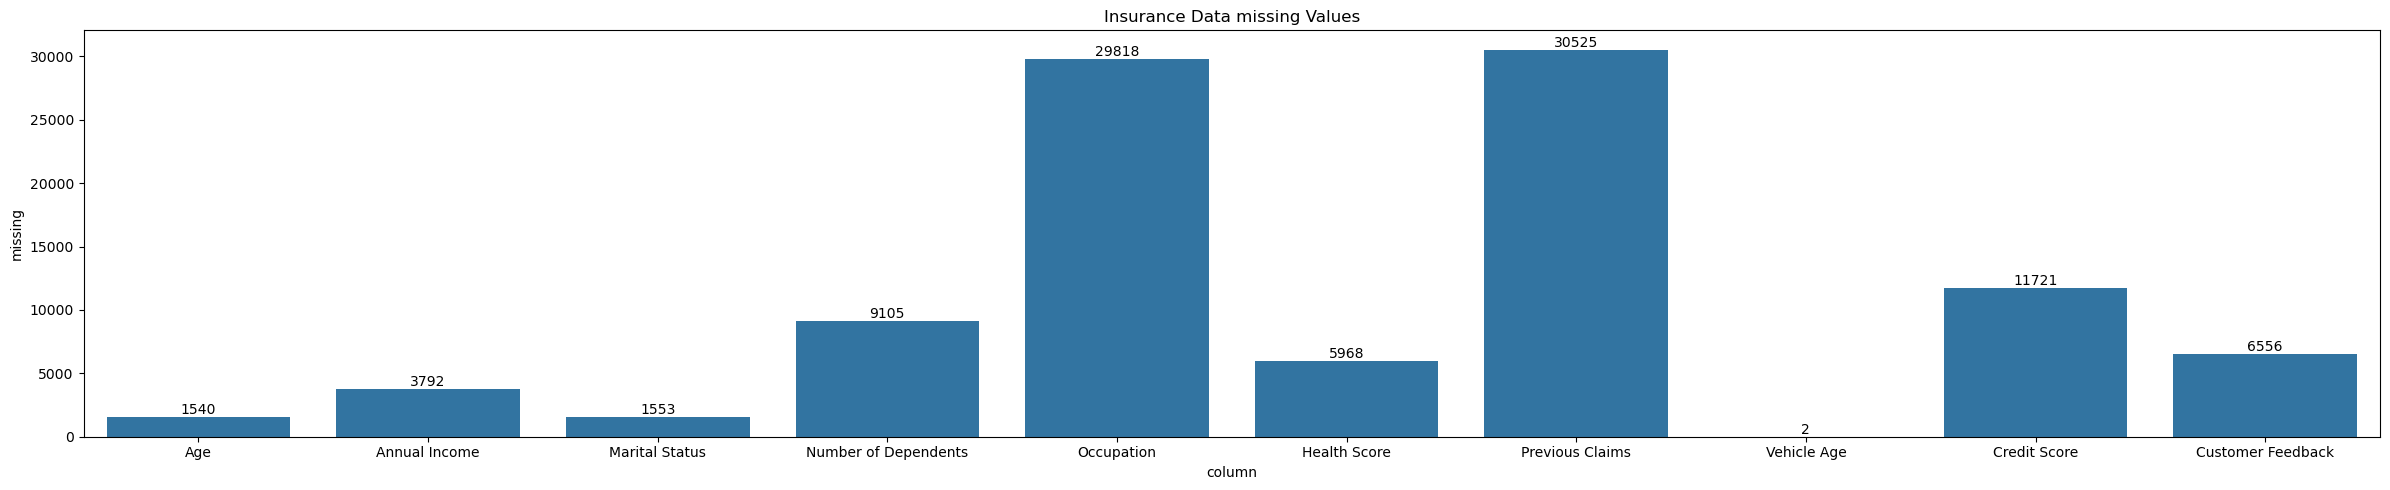

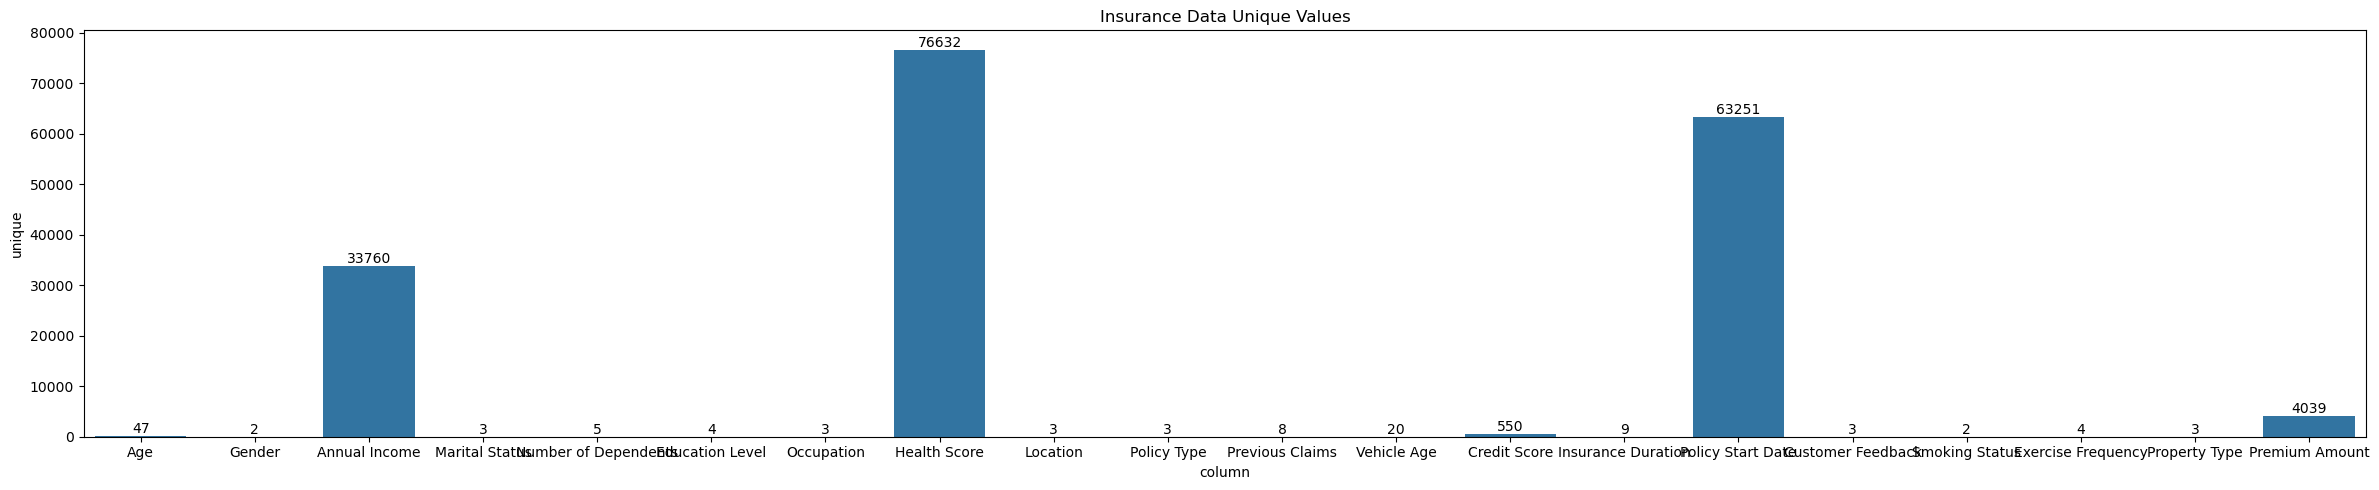

In [180]:
describe_dataframe(df_train, name='Insurance Data', nrows=0, plots=True, info=True)

,column,type,missing,pct_missing,unique,duplicate,min,max,avg,std dev,top value,Freq
0,Age,float64,0,0.000000,47,0,18.000000,64.000000,41.173290,13.444909,nan,nan
1,Gender,object,0,0.000000,2,0,nan,nan,nan,nan,Male,50407
2,Annual Income,float64,0,0.000000,33760,0,2.000000,149996.000000,32424.942160,31608.620253,nan,nan
3,Marital Status,object,0,0.000000,4,0,nan,nan,nan,nan,Single,33251
4,Number of Dependents,float64,0,0.000000,5,0,0.000000,4.000000,2.007250,1.349131,nan,nan
5,Education Level,object,0,0.000000,4,0,nan,nan,nan,nan,Bachelor's,25374
6,Occupation,object,0,0.000000,4,0,nan,nan,nan,nan,Unknown,29818
7,Health Score,float64,0,0.000000,76633,0,2.053458,58.886035,25.548309,11.828520,nan,nan
8,Location,object,0,0.000000,3,0,nan,nan,nan,nan,Suburban,33628
9,Policy Type,object,0,0.000000,3,0,nan,nan,nan,nan,Premium,33844


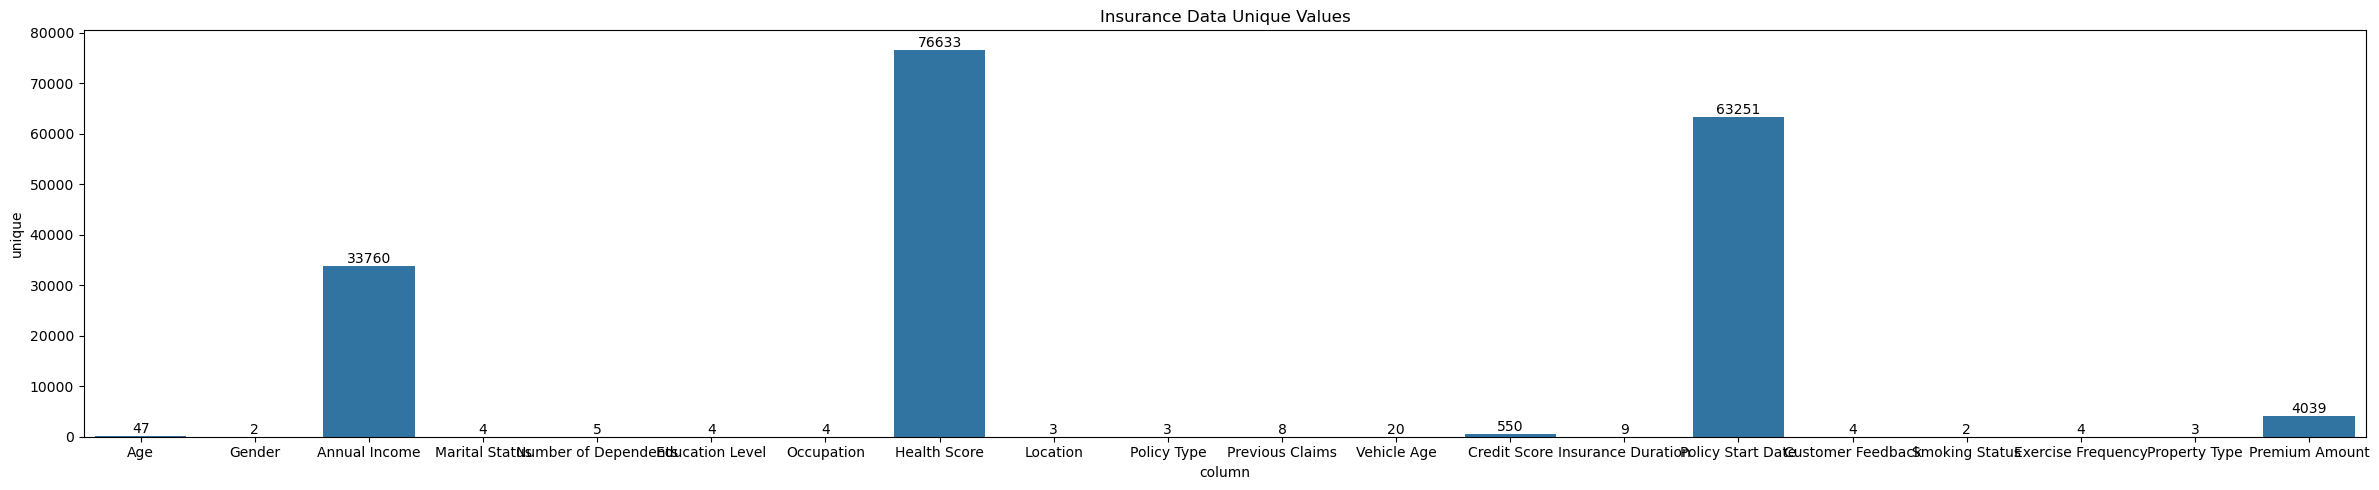

In [181]:
describe_dataframe(df_train_cleaned, name='Insurance Data', nrows=0, plots=True, info=True)

,column,type,missing,pct_missing,unique,duplicate,min,max,avg,std dev,top value,Freq
0,Age,float64,0,0.000000,47,0,18.000000,64.000000,41.173290,13.444909,nan,nan
1,Gender,object,0,0.000000,2,0,nan,nan,nan,nan,Male,50407
2,Annual Income,float64,0,0.000000,33760,0,2.000000,149996.000000,32424.942160,31608.620253,nan,nan
3,Marital Status,object,0,0.000000,4,0,nan,nan,nan,nan,Single,33251
4,Number of Dependents,float64,0,0.000000,5,0,0.000000,4.000000,2.007250,1.349131,nan,nan
5,Education Level,object,0,0.000000,4,0,nan,nan,nan,nan,Bachelor's,25374
6,Occupation,object,0,0.000000,4,0,nan,nan,nan,nan,Unknown,29818
7,Health Score,float64,0,0.000000,76633,0,2.053458,58.886035,25.548309,11.828520,nan,nan
8,Location,object,0,0.000000,3,0,nan,nan,nan,nan,Suburban,33628
9,Policy Type,object,0,0.000000,3,0,nan,nan,nan,nan,Premium,33844


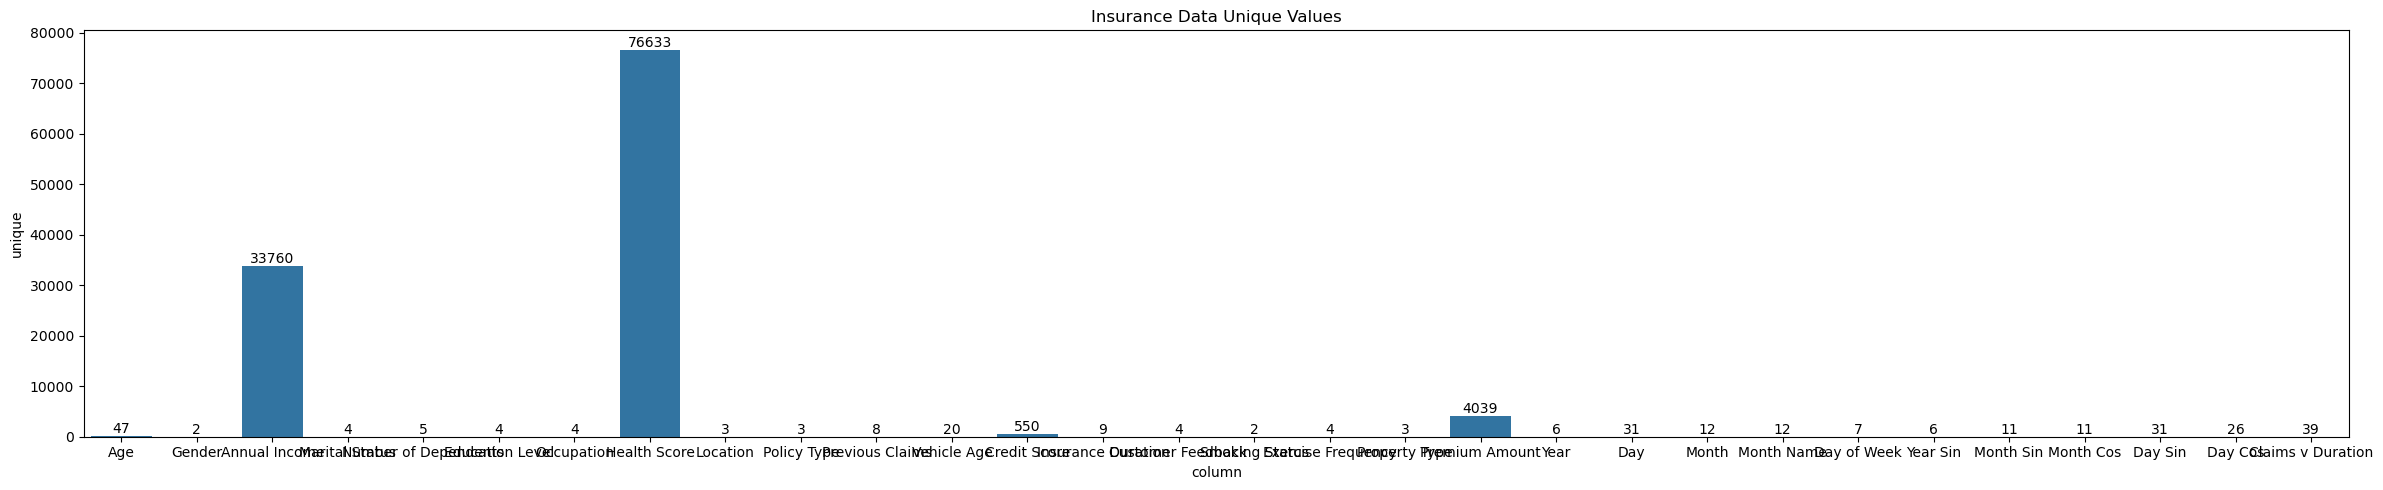

In [182]:
describe_dataframe(df_train_prepared, name='Insurance Data', nrows=0, plots=True, info=True)

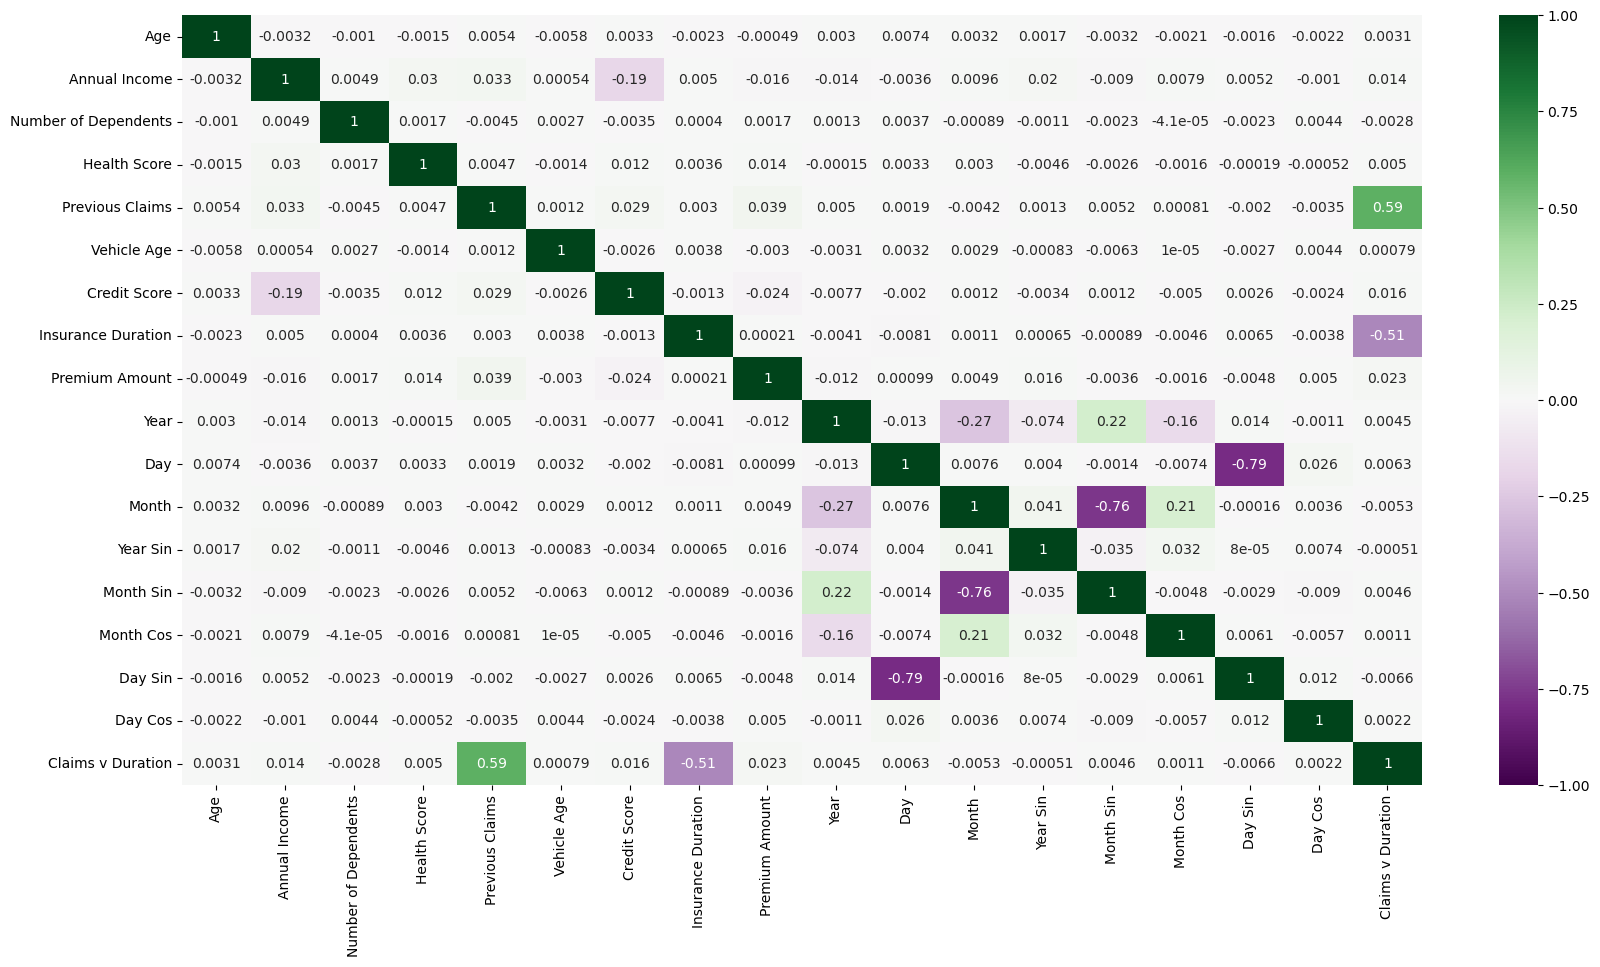

In [183]:

num_cols = get_num_cols(df_train_prepared)

plt.figure(figsize=(20,10))
sns.heatmap(df_train_prepared[num_cols].corr(),
            vmin=-1,
            vmax=1,
            center=0,
            annot=True,
            cmap='PRGn')
plt.show()

In [184]:
from sklearn.model_selection import train_test_split

# Split into 80% training data and 20% testing data

X = df_train_prepared.drop('Premium Amount', axis=1)
y = df_train_prepared['Premium Amount'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)

# y target has a right skew distribution so we log it 
y_log_train = np.log1p(y_train)
y_log_test = np.log1p(y_test)

In [185]:
# Pipeline constructor used to run transformation steps in order
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

# Define a custom transformer for frequency encoding
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        # Calculate the frequency for each category in the columns
        self.freq_dict = {}
        for col in self.columns:
            self.freq_dict[col] = X[col].value_counts() / len(X)
        return self

    def transform(self, X):
        X_copy = X.copy()
        # Apply frequency encoding based on training set frequencies
        for col in self.columns:
            X_copy[col] = X_copy[col].map(self.freq_dict[col]).fillna(0)
        return X_copy


num_cols = get_num_cols(X)
cat_cols = get_cat_cols(X)


# Define a ColumnTransformer for scaling numeric columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        #('cat',OneHotEncoder(), cat_cols)
        ('cat',FrequencyEncoder(columns=cat_cols), cat_cols)
    ],
    remainder='passthrough'
)

# Create a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

# Fit and transform training data
X_train_prepared= pipeline.fit_transform(X_train)


# Transform validation and test data usingthe same pipeline
X_test_prepared= pipeline.transform(X_test)



In [186]:
from keras import backend as K
from sklearn.metrics import mean_squared_log_error

#Define a custom RMSLE metric
def rmsle(y_true, y_pred):  
    # To avoid log(0), clip values to a small positive constant (epsilon)
    epsilon = tf.keras.backend.epsilon()

    # Apply log transformation
    #y_true_log = tf.math.log1p(y_true)  # Log-transform the true values
    #y_pred_log = tf.math.log1p(y_pred)  # Log-transform the clipped predicted values
    
    # RMSLE formula
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [187]:
from tensorflow import keras
from tensorflow.keras import backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [188]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

# Parameter grid
param_grid = {
    'num_leaves': [15, 31, 70],       # Number of leaves in a tree
    #'max_depth': [-1, 5, 10],        # limit on depth
    'learning_rate': [0.01,.001,.0001], # Step size for updates
    'n_estimators': [200, 500, 1000], # Number of boosting rounds
    #'subsample': [0.8, 1.0],
    #'colsample_bytree': [0.8, 1.0]
}

lgbm = lgb.LGBMRegressor(random_state=SEED)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",  # Use RMSE as the evaluation metric
    cv=5,  # 3-fold cross-validation
    verbose=2,  # Output progress messages
    n_jobs=-1  # Use all available cores
)

#grid_search.fit(X_train_prepared, y_log_train,feature_name=X.columns.tolist())

#best_params = grid_search.best_params_
#best_rmse = (-grid_search.best_score_) ** 0.5

#print("Best parameters:",best_params)
#print("Best RMSE:", best_rmse)

In [189]:

best_params = {'learning_rate': 0.01, 'n_estimators': 1000, 'num_leaves': 31}

# Initialize the LGBMRegressor
model = lgb.LGBMRegressor(
    **best_params,
    boosting_type='gbdt',  # Gradient Boosted Decision Trees
    random_state=SEED        # Ensure reproducibility
)

# Train the model
model.fit(
    X_train_prepared, 
    y_log_train, 
    eval_set=[(X_test_prepared, y_log_test)], 
    eval_metric='rmse',        # Evaluation metric (root mean squared error)
    callbacks=[lgb.early_stopping(25)]  # Stop early if no improvement
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1087
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 29
[LightGBM] [Info] Start training from score 6.597170
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[434]	valid_0's rmse: 1.05258	valid_0's l2: 1.10793


LGBMRegressor(learning_rate=0.01, n_estimators=1000, random_state=69)

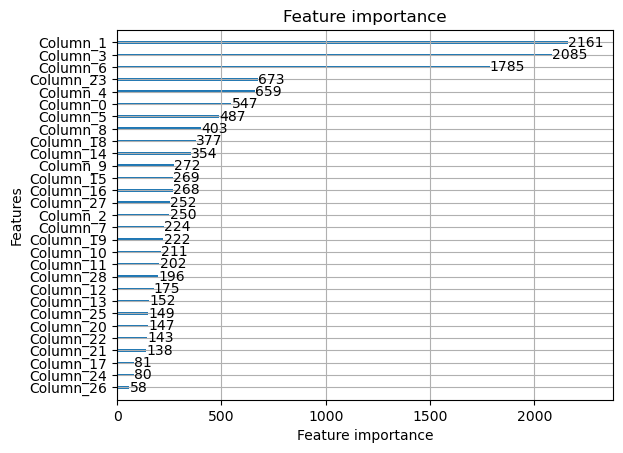

In [190]:
import matplotlib.pyplot as plt
# Plot feature importance
lgb.plot_importance(model, max_num_features=X_train_prepared.shape[1], importance_type='split')
plt.show()

In [191]:
# Predict on test set
y_test_pred = model.predict(X_test_prepared)

In [192]:
from sklearn.metrics import root_mean_squared_error

# Calculate RMSE
rmse = root_mean_squared_error(y_log_test, y_test_pred)
print(f"RMSE: {rmse:.5f}")

RMSE: 1.05258


In [193]:
# RMSE: 1.05258 (Freq Encode)
# RMSE: 1.05298 (Cat Encode)

<Axes: >

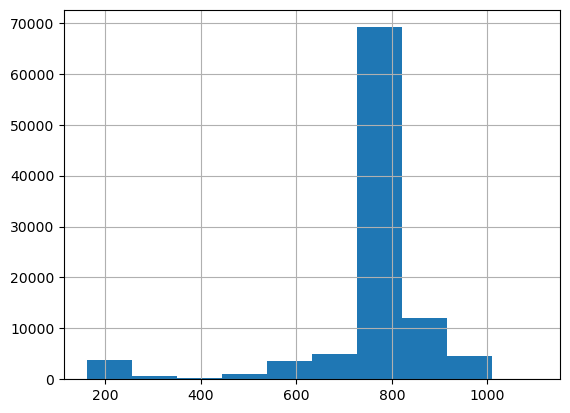

In [194]:
# Create final predictions
df_solve_cleaned = clean_dataframe(df_solve)
df_solve_prepared = transform_dataframe(df_solve_cleaned)
X_solve_prepared= pipeline.transform(df_solve_prepared)


y_log_solve = model.predict(X_solve_prepared)

y_solve = np.expm1(y_log_solve)  # Inverse of log1p (to get the original scale)

df_y_solve = pd.DataFrame(y_solve, columns=['Premium Amount'])
df_final = pd.merge(df_solve_id, df_y_solve, left_index=True, right_index=True, how='inner')
df_final.to_csv('Predictions.csv', index=False)

df_final['Premium Amount'].hist()

In [195]:
# Recent RMSE = 1.05

In [196]:
# BEST RMSE = 1.04352